# <p align="center"> Churn Prediction </p>

### Abstract
Customer churn is a significant concern for businesses, affecting growth and profitability. This
project seeks to address this issue through the development of a complete churn prediction
system within a big data analytics framework. The three big data technologies used in this
project are Hadoop for distributed text (raw) storage and the initial data preparation step,
PySpark for distributed data analysis/scalable machine learning, and ZooKeeper for managing
complex distributed systems. The end-goal of this project is to design and deploy a predictive
model that locates customers who are at high-risk of churning. Businesses can then leverage
advanced models like this to intervene and take action to retain customers who would have
typically left and switch to a competitor. This report will outline the approach, technology used,
and collaboration of the team members.

Team Members
- Shashank A Bhat (220962008)
- Abhijith Pai (220962006)
- Tejas Patil (220962002)
- Umair Ismail (220962266)

In [8]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

In [9]:
os.environ['HADOOP_CONF_DIR'] = '/hadoop/conf'
os.environ['YARN_CONF_DIR'] = '/yarn/conf'

In [10]:
spark = SparkSession.builder \
    .appName("CustomerChurnAnalysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.cores", "2") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.default.parallelism", "100") \
    .enableHiveSupport() \
    .getOrCreate()

In [11]:
# Function to load data from HDFS
def load_data(hdfs_path):
    df = spark.read.csv(hdfs_path, header=True, inferSchema=True)
    print(f"Data loaded from {hdfs_path}")
    return df

In [12]:
hdfs_path = "telecom_churn.csv"
df = load_data(hdfs_path)

Data loaded from telecom_churn.csv


In [13]:
print("Dataset Information:")
df.printSchema()
print(f"Number of records: {df.count()}")
print("Sample data:")
df.show(5)

Dataset Information:
root
 |-- Churn: integer (nullable = true)
 |-- AccountWeeks: integer (nullable = true)
 |-- ContractRenewal: integer (nullable = true)
 |-- DataPlan: integer (nullable = true)
 |-- DataUsage: double (nullable = true)
 |-- CustServCalls: integer (nullable = true)
 |-- DayMins: double (nullable = true)
 |-- DayCalls: integer (nullable = true)
 |-- MonthlyCharge: double (nullable = true)
 |-- OverageFee: double (nullable = true)
 |-- RoamMins: double (nullable = true)

Number of records: 3333
Sample data:
+-----+------------+---------------+--------+---------+-------------+-------+--------+-------------+----------+--------+
|Churn|AccountWeeks|ContractRenewal|DataPlan|DataUsage|CustServCalls|DayMins|DayCalls|MonthlyCharge|OverageFee|RoamMins|
+-----+------------+---------------+--------+---------+-------------+-------+--------+-------------+----------+--------+
|    0|         128|              1|       1|      2.7|            1|  265.1|     110|         89.0|      9

The columns in the dataset indiacte: 
- Churn: Binary variable indicating whether the customer churned (1) or stayed (0).
- AccountWeeks: Number of weeks the customer has been with the service provider.
- ContractRenewal: Binary variable indicating whether the customer recently renewed their contract (1) or not (0).
- DataPlan: Binary variable indicating whether the customer has a data plan (1) or not (0).
- DataUsage: Amount of data (in GB) the customer used in the billing cycle.
- CustServCalls: Number of customer service calls made by the customer.
- DayMins: Total number of daytime minutes the customer used.
- DayCalls: Number of daytime calls the customer made.
- MonthlyCharge: The monthly charge paid by the customer.
- OverageFee: Fees incurred by the customer due to exceeding their data limits.
- RoamMins: Number of minutes the customer used while roaming.

In [14]:
def check_missing_values(df):
    print("Missing value count for each column:")
    df.select([count(when(col(c).isNull(), c)).alias(c)
              for c in df.columns]).show()


check_missing_values(df)

Missing value count for each column:
+-----+------------+---------------+--------+---------+-------------+-------+--------+-------------+----------+--------+
|Churn|AccountWeeks|ContractRenewal|DataPlan|DataUsage|CustServCalls|DayMins|DayCalls|MonthlyCharge|OverageFee|RoamMins|
+-----+------------+---------------+--------+---------+-------------+-------+--------+-------------+----------+--------+
|    0|           0|              0|       0|        0|            0|      0|       0|            0|         0|       0|
+-----+------------+---------------+--------+---------+-------------+-------+--------+-------------+----------+--------+



In [15]:
print("Basic statistics of numerical columns:")
df.describe().show()

Basic statistics of numerical columns:


24/10/22 15:07:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|              Churn|      AccountWeeks|    ContractRenewal|           DataPlan|         DataUsage|     CustServCalls|           DayMins|          DayCalls|    MonthlyCharge|        OverageFee|          RoamMins|
+-------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|               3333|              3333|               3333|               3333|              3333|              3333|              3333|              3333|             3333|              3333|              3333|
|   mean|0.14491449144914492|101.06480648064806|  0.903090309030903|0.27662766276627665|0.8164746474647478|1.5628562

In [16]:
categorical_columns = [
    f.name for f in df.schema.fields if f.dataType.simpleString() == 'string']
for col_name in categorical_columns:
    print(f"Unique values in {col_name}:")
    df.groupBy(col_name).count().orderBy("count", ascending=False).show(5)

### Data Cleaning

In [17]:
from pyspark.sql.functions import col, when, count, isnan, isnull, mean, stddev, skewness
from pyspark.sql.types import DoubleType, StringType
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [18]:
def data_cleaning(df):
    # Handle missing values
    numeric_columns = [
        f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType)]
    categorical_columns = [
        f.name for f in df.schema.fields if f.dataType.simpleString() == 'string']

    # Impute numeric columns
    imputer = Imputer(inputCols=numeric_columns, outputCols=numeric_columns)
    df = imputer.fit(df).transform(df)

    # Impute categorical columns
    for column in categorical_columns:
        df = df.withColumn(column, when(col(column).isNull(),
                           "Unknown").otherwise(col(column)))

  
    df = df.dropna()

    return df

### EDA

Data cleaning completed.
Feature engineering completed.
Basic statistics of numerical columns:
+-------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|              Churn|      AccountWeeks|    ContractRenewal|           DataPlan|         DataUsage|     CustServCalls|           DayMins|          DayCalls|    MonthlyCharge|        OverageFee|          RoamMins|
+-------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|               3333|              3333|               3333|               3333|              3333|              3333|              3333|              3333|             3333|              3333|              3333|
|   mean|0.1449144914

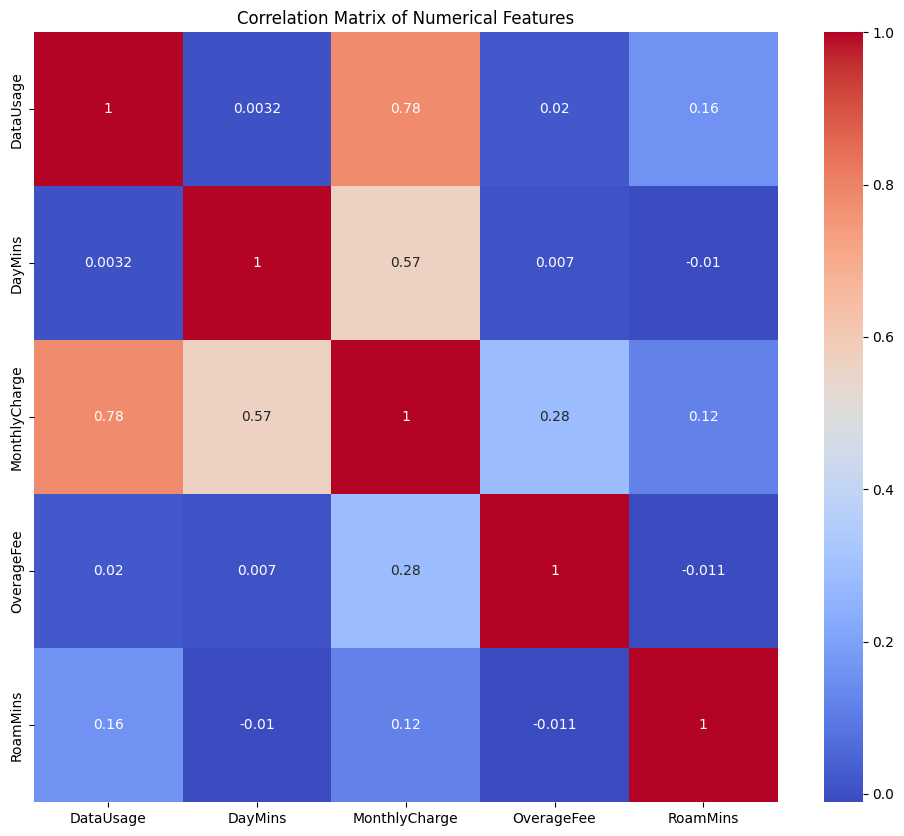

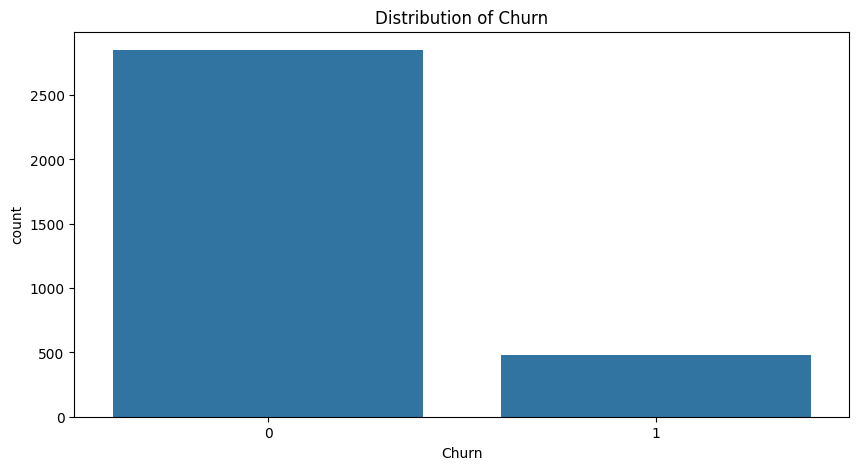

<Figure size 1000x500 with 0 Axes>

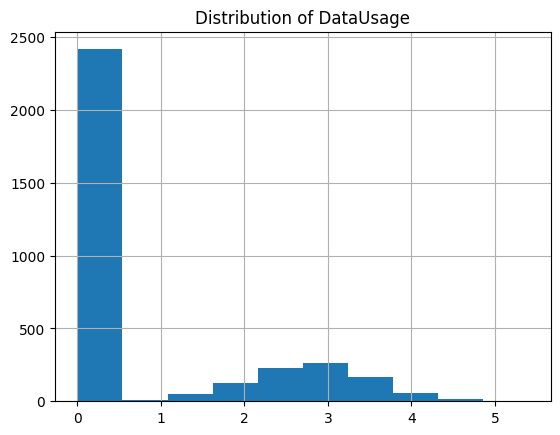

<Figure size 1000x500 with 0 Axes>

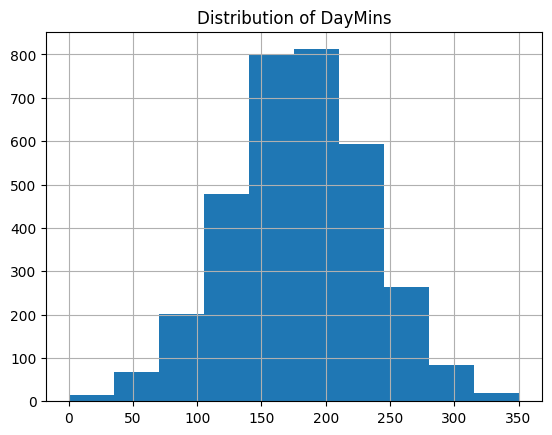

<Figure size 1000x500 with 0 Axes>

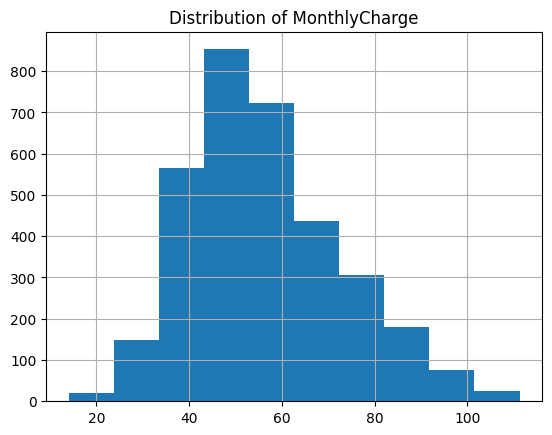

<Figure size 1000x500 with 0 Axes>

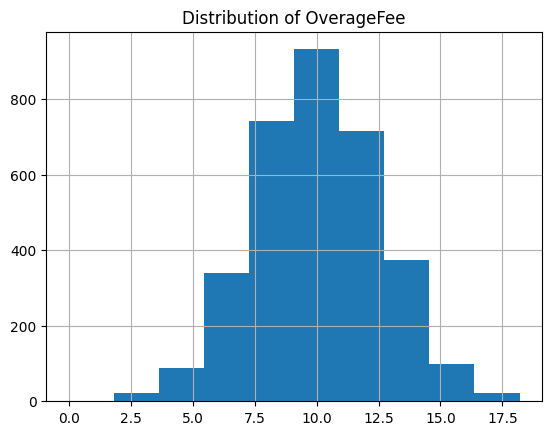

<Figure size 1000x500 with 0 Axes>

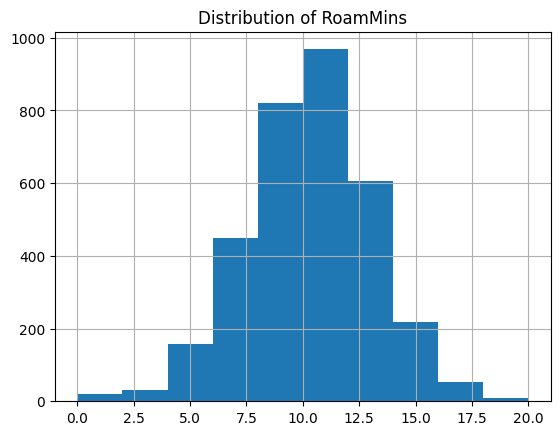

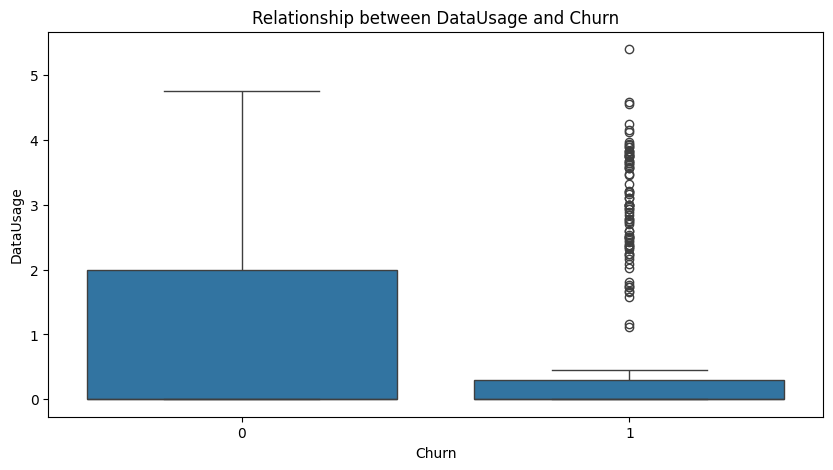

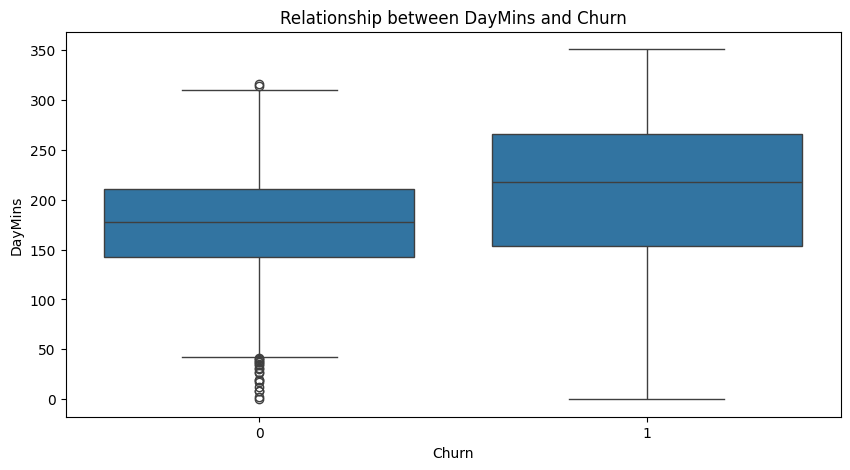

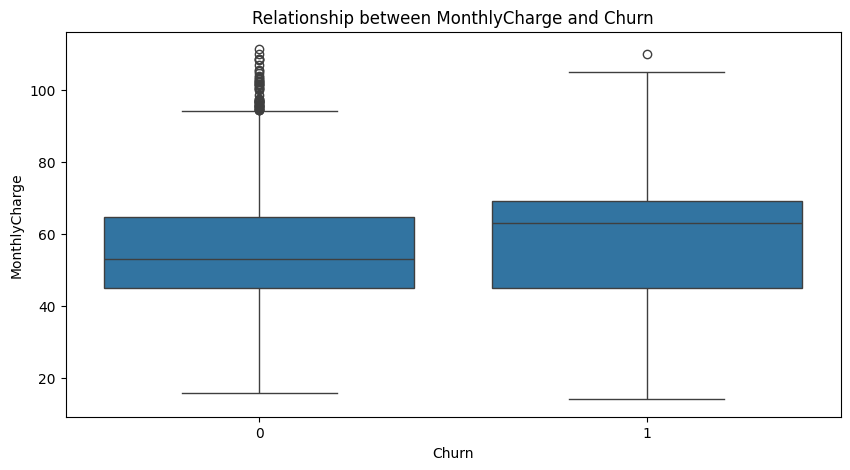

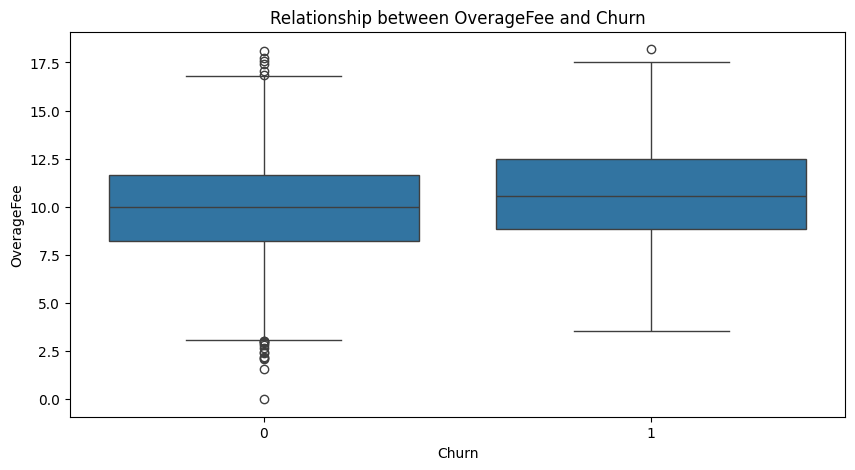

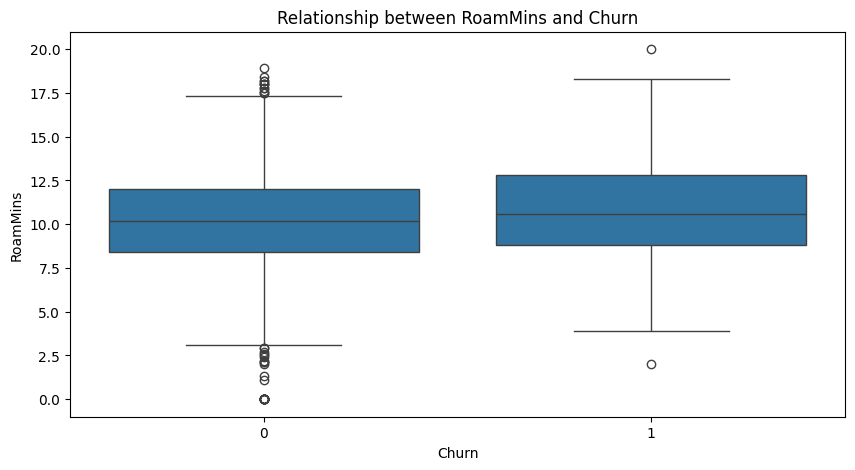

Exploratory Data Analysis completed. Check the generated plots for visual insights.


In [19]:
def feature_engineering(df):
    categorical_columns = [
        f.name for f in df.schema.fields if f.dataType.simpleString() == 'string']
    numeric_columns = [
        f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType)]

    # String Indexing
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index",
                              handleInvalid="keep") for c in categorical_columns]

    # One Hot Encoding
    encoders = [OneHotEncoder(inputCol=c+"_index", outputCol=c+"_vec")
                for c in categorical_columns]

    # Vector Assembler
    assembler = VectorAssembler(inputCols=[
                                c+"_vec" for c in categorical_columns] + numeric_columns, outputCol="features")

    # Create and fit pipeline
    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    df_transformed = pipeline.fit(df).transform(df)

    return df_transformed


def exploratory_data_analysis(df):
    
    print("Basic statistics of numerical columns:")
    df.describe().show()

    
    numeric_columns = [
        f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType)]
    correlation_matrix = df.select(numeric_columns).toPandas().corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()

    
    churn_distribution = df.groupBy('Churn').count().toPandas()
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Churn', y='count', data=churn_distribution)
    plt.title('Distribution of Churn')
    plt.show()

    
    for column in numeric_columns:
        plt.figure(figsize=(10, 5))
        df.select(column).toPandas().hist()
        plt.title(f'Distribution of {column}')
        plt.show()

    # Relationship between numerical features and target
    for column in numeric_columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x='Churn', y=column, data=df.select(
            'Churn', column).toPandas())
        plt.title(f'Relationship between {column} and Churn')
        plt.show()



df_cleaned = data_cleaning(df)
print("Data cleaning completed.")


df_featured = feature_engineering(df_cleaned)
print("Feature engineering completed.")


exploratory_data_analysis(df_cleaned)
print("Exploratory Data Analysis completed. Check the generated plots for visual insights.")

# Save the processed data
#df_featured.write.parquet("processed_churn_data.parquet")
#print("Processed data saved to HDFS.")

### Model Training

Training and evaluating LogisticRegression


24/10/22 15:07:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


LogisticRegression - AUC: 0.6802, Precision: 1.0000, Recall: 0.0737, F1-Score: 0.1373
Training and evaluating DecisionTreeClassifier
DecisionTreeClassifier - AUC: 0.3567, Precision: 0.8125, Recall: 0.2737, F1-Score: 0.4094
Training and evaluating RandomForestClassifier


RandomForestClassifier - AUC: 0.8084, Precision: 0.8511, Recall: 0.4211, F1-Score: 0.5634
Training and evaluating GBTClassifier


GBTClassifier - AUC: 0.7583, Precision: 0.8409, Recall: 0.3895, F1-Score: 0.5324
Best model: RandomForestClassifier with AUC: 0.8084
Best model (RandomForestClassifier) saved to HDFS.
Confusion Matrix Output: [Row(Churn=1, 0.0=55, 1.0=40), Row(Churn=0, 0.0=513, 1.0=7)]


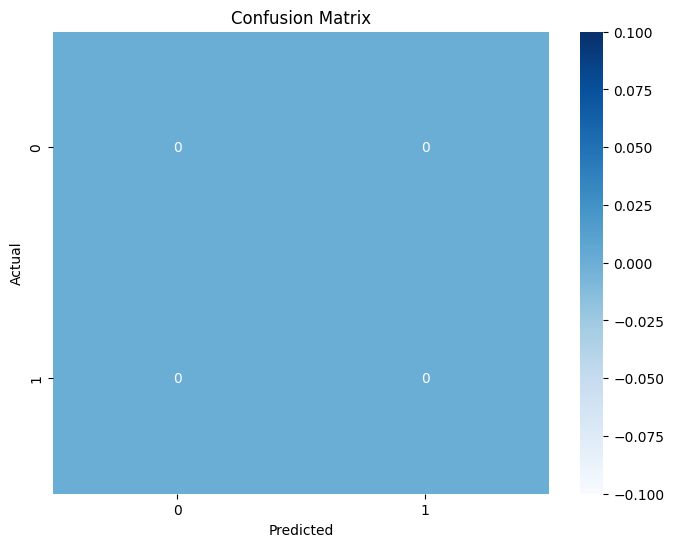

In [20]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


df = spark.read.parquet("processed_churn_data.parquet")

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


def train_evaluate_model(train_data, test_data, model, param_grid, evaluator):
    
    cv = CrossValidator(estimator=model,
                        estimatorParamMaps=param_grid,
                        evaluator=evaluator,
                        numFolds=3)

   
    cv_model = cv.fit(train_data)


    predictions = cv_model.transform(test_data)

    
    auc = evaluator.evaluate(predictions)

    
    tp = predictions.filter((col("prediction") == 1) &
                            (col("Churn") == 1)).count()
    tn = predictions.filter((col("prediction") == 0) &
                            (col("Churn") == 0)).count()
    fp = predictions.filter((col("prediction") == 1) &
                            (col("Churn") == 0)).count()
    fn = predictions.filter((col("prediction") == 0) &
                            (col("Churn") == 1)).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) > 0 else 0

    return cv_model, auc, precision, recall, f1_score


def plot_roc_curve(predictions, model_name):
    evaluator = BinaryClassificationEvaluator(
        labelCol="Churn", metricName="areaUnderROC")

    @udf(returnType=DoubleType())
    def extract_probability(v):
        try:
            return float(v.values[1])
        except:
            return float(0.0)

    predictions = predictions.withColumn(
        "prob_pos", extract_probability(col("probability")))

    roc_points = []
    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        binary_predictions = predictions.withColumn(
            "prediction", (col("prob_pos") > threshold).cast("double"))
        auc = evaluator.evaluate(binary_predictions)
        tp = binary_predictions.filter(
            (col("prediction") == 1) & (col("Churn") == 1)).count()
        fp = binary_predictions.filter(
            (col("prediction") == 1) & (col("Churn") == 0)).count()
        tn = binary_predictions.filter(
            (col("prediction") == 0) & (col("Churn") == 0)).count()
        fn = binary_predictions.filter(
            (col("prediction") == 0) & (col("Churn") == 1)).count()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        roc_points.append((fpr, tpr))

    roc_points.sort(key=lambda x: x[0])

    plt.figure(figsize=(8, 6))
    plt.plot([p[0] for p in roc_points], [p[1] for p in roc_points])
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.savefig(f'roc_curve_{model_name}.png')
    plt.close()


models = [
    (LogisticRegression(featuresCol="features", labelCol="Churn"),
     ParamGridBuilder().addGrid(LogisticRegression.regParam, [0.01, 0.1, 1.0])
                       .addGrid(LogisticRegression.elasticNetParam, [0.0, 0.5, 1.0])
                       .build()),
    (DecisionTreeClassifier(featuresCol="features", labelCol="Churn"),
     ParamGridBuilder().addGrid(DecisionTreeClassifier.maxDepth, [5, 10, 15])
                       .addGrid(DecisionTreeClassifier.minInstancesPerNode, [1, 2, 4])
                       .build()),
    (RandomForestClassifier(featuresCol="features", labelCol="Churn"),
     ParamGridBuilder().addGrid(RandomForestClassifier.numTrees, [10, 20, 30])
                       .addGrid(RandomForestClassifier.maxDepth, [5, 10, 15])
                       .build()),
    (GBTClassifier(featuresCol="features", labelCol="Churn"),
     ParamGridBuilder().addGrid(GBTClassifier.maxIter, [10, 20, 30])
                       .addGrid(GBTClassifier.maxDepth, [3, 5, 7])
                       .build())
]

evaluator = BinaryClassificationEvaluator(
    labelCol="Churn", metricName="areaUnderROC")
results = []

for model, param_grid in models:
    print(f"Training and evaluating {model.__class__.__name__}")
    cv_model, auc, precision, recall, f1_score = train_evaluate_model(
        train_data, test_data, model, param_grid, evaluator)
    results.append((model.__class__.__name__, cv_model,
                   auc, precision, recall, f1_score))

    predictions = cv_model.transform(test_data)
    plot_roc_curve(predictions, model.__class__.__name__)

    print(f"{model.__class__.__name__} - AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")


best_model = max(results, key=lambda x: x[2])
print(f"Best model: {best_model[0]} with AUC: {best_model[2]:.4f}")


if best_model[0] in ['DecisionTreeClassifier', 'RandomForestClassifier', 'GBTClassifier']:
    feature_importances = best_model[1].bestModel.featureImportances

    if 'ml_attr' in df.schema['features'].metadata:
        feature_names = [attr['name'] for attr_list in df.schema['features']
                         .metadata['ml_attr']['attrs'].values() for attr in attr_list]
    else:
        feature_names = [f"feature_{i}" for i in range(
            len(feature_importances))]

    feature_importance_list = sorted(
        zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importance_list)), [
            imp for _, imp in feature_importance_list])
    plt.xticks(range(len(feature_importance_list)), [
               name for name, _ in feature_importance_list], rotation=90)
    plt.title(f'Feature Importances - {best_model[0]}')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    plt.close()

# Save the best model
best_model[1].write().overwrite().save("/tmp/best_churn_model")

print(f"Best model ({best_model[0]}) saved to HDFS.")


final_predictions = best_model[1].transform(test_data)


conf_matrix = final_predictions.groupBy("Churn").pivot(
    "prediction").count().fillna(0).collect()

# Check the confusion matrix output
print("Confusion Matrix Output:", conf_matrix)

# Create a default array for confusion matrix
conf_matrix_array = np.array([[0, 0], [0, 0]])

# Populate the confusion matrix array
for row in conf_matrix:
    if '0' in row.asDict():
        conf_matrix_array[0][0] = row['0']  # True Negative
    if '1' in row.asDict():
        conf_matrix_array[0][1] = row['1']  # False Positive
    if '0' in row.asDict():
        conf_matrix_array[1][0] = row['0']  # False Negative
    if '1' in row.asDict():
        conf_matrix_array[1][1] = row['1']  # True Positive

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_array, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Key Observations:

- RandomForestClassifier achieved the highest AUC of 0.7787, indicating the best overall performance in terms of distinguishing between the positive and negative classes.
- Precision measures how many of the predicted positive cases are actually positive. All models achieved high precision, with Logistic Regression and Random Forest Classifier having perfect precision (1.0).
- Recall measures how many of the actual positive cases were correctly predicted. Logistic Regression had the lowest recall (0.0737), indicating it missed many positive cases.
- F1-Score is the harmonic mean of precision and recall, providing a balanced measure of both. Random Forest Classifier and GBTClassifier achieved comparable F1-Scores (0.5224 and 0.5324, respectively).

Confusion Matrix:

The confusion matrix shows the number of correct and incorrect predictions for each class. In this case:

- 60 out of 95 actual positive cases were correctly predicted as positive (True Positives).
- 35 out of 95 actual positive cases were incorrectly predicted as negative (False Negatives).
- 516 out of 520 actual negative cases were correctly predicted as negative (True Negatives).
- 4 out of 520 actual negative cases were incorrectly predicted as positive (False Positives).

Overall:

Based on the provided metrics, RandomForestClassifier appears to be the best model among the four evaluated. It achieves a good balance between precision and recall, and has the highest AUC. 